In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

A simple example:

$y = 4x + x^3$

In [2]:
x = tf.Variable(1.0)

with tf.GradientTape() as g:
    y = 4*x + x**3
    
# y' = 4 + 3 x^2 = 7
dy_dx = g.gradient(y, x)
print('dy/dx = ', dy_dx)

dy/dx =  tf.Tensor(7.0, shape=(), dtype=float32)


Differentiate:

$y = x_1 + x_2^2$, $x_1 = 1$, $x_2 = 2$

with respect to $x_1$ and $x_2$.

$$\frac{\partial y}{\partial x_1} = 1$$

$$\frac{\partial y}{\partial x_2} = 2x_2 = 4$$

In [3]:
x1 = tf.Variable(1.0)
x2 = tf.Variable(2.0)

with tf.GradientTape() as g:
    y = x1 + x2**2
    
dy_dx1, dy_dx2 = g.gradient(y, [x1,x2])
print('dy/dx1 = ', dy_dx1.numpy(), '; dy/dx2 = ', dy_dx2.numpy())

dy/dx1 =  1.0 ; dy/dx2 =  4.0


We can control which input is considered an independent variable versus a constant value.

`gradient` will return `None` when the input is not a `tf.Variable`.

In [4]:
# Standard trainable variable
x0 = tf.Variable(2.0, name='x0')
# A tf.constant is not a variable
c1 = tf.constant(-2.0, name='c1')
# Not trainable because we specify trainable=False
c2 = tf.Variable(-1.0, name='c2', trainable=False)
# variable + tensor returns a tensor. So c3 is not a tf.Variable.
c3 = tf.Variable(1.0, name='c3') + 1.0
# A variable but not used to compute y
x4 = tf.Variable(0., name='x4')

with tf.GradientTape() as g:
    z = x0 + c1
    y = z**2 + (c2**3) + 4*c3

grad = g.gradient(y, [x0, c1, c2, c3, x4])

for dy_dxi in grad:
    print(dy_dxi)

tf.Tensor(0.0, shape=(), dtype=float32)
None
None
None
None


A `tf.Tensor` can be used as a variable using the `watch` function.

In [5]:
x = tf.constant(-3.)

with tf.GradientTape() as g:
    g.watch(x)
    y = tf.math.reduce_sum(x**4)

print(g.gradient(y, x))  # 4x^3 = 4 27 = 108

tf.Tensor(-108.0, shape=(), dtype=float32)


You can use tensor variables as input. This just means you differentiate with respect to all the variables in the tensor.

In [6]:
x = tf.Variable([1, -3.0])
with tf.GradientTape() as g:
    y = tf.math.reduce_sum(x**2)

print(x.numpy())
print(y.numpy()) # x[0]**2 + x[1]**2 = 1 + 9 = 10
print(g.gradient(y, x))  # (2x[0], 2x[1]) = (2,-6)

[ 1. -3.]
10.0
tf.Tensor([ 2. -6.], shape=(2,), dtype=float32)


When `g.gradient` is called with a tensor dependent variable (tensor target), it returns the sum of the derivatives for each component.

In [7]:
x = tf.Variable(-1.)
with tf.GradientTape() as g:
    y = [2*x,x**4]

print([y[i].numpy() for i in range(2)]) # [2,1]
print(g.gradient(y, x))  # 2 + 4x^3 = 2 - 4 = -2

[-2.0, 1.0]
tf.Tensor(-2.0, shape=(), dtype=float32)


By default, when you call `g.gradient`, all resources required to compute the gradient are released. This allows saving memory. However, there are cases when you want to call `g.gradient` several times for example to differentiate different functions. In that case, you must use the option `persistent=True`.

In [8]:
x = tf.Variable([1, -3.0])
with tf.GradientTape(persistent=True) as g:
    y = 2*x
    z = y**2

print(x.numpy())
print(y.numpy())
print(g.gradient(y, x))  # [2,2]
print(g.gradient(z, x))  # dz/dx = d(4x^2)/dx 8x = [8, -24]
del g # release resources

[ 1. -3.]
[ 2. -6.]
tf.Tensor([2. 2.], shape=(2,), dtype=float32)
tf.Tensor([  8. -24.], shape=(2,), dtype=float32)


It's very easy to differentiate functions and plot the derivative.

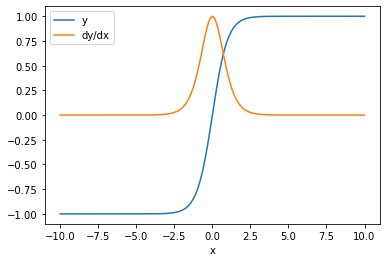

In [9]:
x = tf.linspace(-10.0, 10.0, 129) # A tf.Tensor, not a tf.Variable

with tf.GradientTape() as g:
    g.watch(x)
    y = tf.math.tanh(x)

dy_dx = g.gradient(y, x)

plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
plt.xlabel('x')
plt.savefig('fig/autodiff_tanh.png',dpi=300)

Let's differentiate a DNN model with respect to its weights and biases

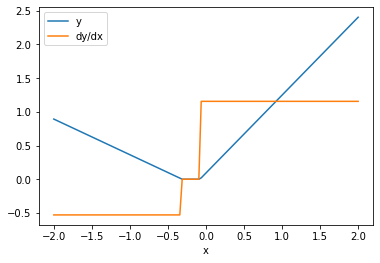

In [10]:
def layer_1(units):
    initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5)
    return tf.keras.layers.Dense(units, dtype='float64',\
                                 bias_initializer=initializer,\
                                 activation=tf.keras.activations.relu)

def layer_2(units):
    return tf.keras.layers.Dense(units, dtype='float64', activation=tf.keras.activations.linear)
    
class AD_Model(tf.keras.models.Model):
    def __init__(self):
        super(AD_Model, self).__init__()
        self.dense_1 = layer_1(2)
        self.dense_2 = layer_2(1)        

    # Forward pass
    def call(self, inputs):
        x = self.dense_1(inputs)        
        y = self.dense_2(x)
        return y
    
def reshape_2d(x):
    return tf.reshape( x, (x.shape[0], 1) )
    
# Initialize model
model = AD_Model()
model.build((1,1))

# Plot our model and its derivative
x = reshape_2d( tf.linspace(-2.0, 2.0, 129) )

with tf.GradientTape() as g:
    g.watch(x)    
    y = model(x)
    
dy_dx = g.gradient(y, x)

plt.plot(x, y, label='y')
plt.plot(x, dy_dx, label='dy/dx')
plt.legend()
plt.xlabel('x')
plt.savefig('fig/pi_model.png',dpi=300)

In [11]:
import scipy.optimize as sopt

In [12]:
# Code to use the scipy optimizers

# use float64 by default
tf.keras.backend.set_floatx("float64")

# Reshape 1D arrays to 2D arrays
def reshape_2d(x):
    return tf.reshape(x,(x.shape[0],1))

# Construct a function that can be minimized by scipy optimize
# starting from a tensorflow model
def function_factory(model, x_train, y_train, validation_data=None,
                     iprint=-1):
    """A factory to create a function required by scipy.optimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        x_train [in]: input for training data.
        y_train [in]: output for training data.
        validation_data [in]: tuple (x_val,y_val) with validation data.
        iprint [in]: sets the frequency with which the loss info is printed out
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters)
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = []  # stitch indices
    part = []  # partition indices

    for i, tensor in enumerate(model.trainable_variables):
        n = np.product(tensor.shape)
        idx.append(tf.reshape(
            tf.range(count, count+n, dtype=tf.int32), tensor.shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)
    
    loss_fun = tf.keras.losses.MeanSquaredError()

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # function to calculate loss value and gradient
    @tf.function
    def tf_tape_grad(params_1d):

        # update the parameters in the model
        assign_new_model_parameters(params_1d)       

        if not (validation_data is None):
          # compute validation loss
          loss_val = model.loss(validation_data[0], validation_data[1])
          # store validation value so we can retrieve later        
          tf.py_function(value_and_grad.hist_loss_val.append,
                        inp=[loss_val], Tout=[])         
              
        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as g:
            g.watch(model.trainable_variables)
            loss = model.loss(x_train,y_train)

        # calculate gradients and convert to 1D tf.Tensor
        grads = g.gradient(loss, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # increment iteration counter
        value_and_grad.iter.assign_add(1)

        # print out iteration & loss
        if (iprint>=1 and value_and_grad.iter%iprint == 0):
            if validation_data is None:
                tf.print("Loss function eval:", value_and_grad.iter, "loss:", loss)
            else:
                tf.print("Loss function eval:", value_and_grad.iter, "loss:", loss,
                        "validation loss:", loss_val)                

        # store loss value so we can retrieve later
        tf.py_function(value_and_grad.hist_loss.append,
                       inp=[loss], Tout=[])       

        return loss, grads

    # create function that will be returned by this factory
    def value_and_grad(params_1d):
        """A function that can be used by optimizer.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """
        return [vv.numpy().astype(np.float64) for vv in tf_tape_grad(tf.constant(params_1d, dtype=tf.float64))]

    # store this information as members so we can use it outside the scope
    value_and_grad.iter = tf.Variable(0)
    value_and_grad.idx = idx
    value_and_grad.part = part
    value_and_grad.shapes = shapes
    value_and_grad.assign_new_model_parameters = assign_new_model_parameters
    value_and_grad.hist_loss = []
    value_and_grad.hist_loss_val = []

    return value_and_grad


# Minimize the loss function using a scipy optimizer
def model_fit(model, x_t, y_t, validation_data=None, epochs=1000, iprint=-1,
              figname=None):
    """ 
    Fit a DNN model using scipy optimizers 
  
  
    Parameters: 
    model: tensorflow DNN model
    x_t: input training data
    y_t: output training data
    validation_data: tuple (x_val,y_val) with validation data
    epochs: maximum number of iterations in optimizer
    iprint: frequency for printing the loss function information. 
            Do not print anything if negative. Otherwise, print
            a line every iprint iteration.
    figname [str]: file name to save the figure of the training loss  
    """

    value_and_grad = function_factory(model, x_t, y_t, validation_data, iprint)

    # convert initial model parameters to a 1D tf.Tensor
    init_params = tf.dynamic_stitch(value_and_grad.idx, model.trainable_variables)

    if (iprint>=1):
        print()

    # train the model
    method = 'L-BFGS-B'
    results = sopt.minimize(fun=value_and_grad, x0=init_params,
                            jac=True, method=method,
                            options={'maxiter': epochs})

    print("\nConvergence information:")
    print('loss:', results.fun)
    # Computing the validation loss  
    if not (validation_data is None):
        val_loss = model.loss(validation_data[0], validation_data[1])
        tf.print('validation loss:', val_loss)
        # tf.make_ndarray(tf.make_tensor_proto(val_loss))    
    print('number function evaluations:', results.nfev)
    print('number iterations:', results.nit)
    print('success flag:', results.success)
    print('convergence message:', results.message)

    value_and_grad.assign_new_model_parameters(results.x)

    # Plot history of loss
    plt.figure()   
    plt.plot(value_and_grad.hist_loss, label='loss')
    if not (validation_data is None): 
        plt.plot(value_and_grad.hist_loss_val, label='validation')
    plt.legend()
    plt.xlabel('epoch')
    plt.yscale('log')
    if validation_data is None:    
        plt.title('Training loss')
    else:
        plt.title('Training and validation losses')

    if not (figname is None):
        plt.savefig(figname,dpi=300)

    return results


Loss function eval: 200 loss: 0.014157640631310642 validation loss: 0.013470875041093677
Loss function eval: 400 loss: 7.3921722300696047e-05 validation loss: 7.9364547318050427e-05
Loss function eval: 600 loss: 3.2806044835798076e-05 validation loss: 3.6002636051080117e-05

Convergence information:
loss: 7.689206662830905e-06
validation loss: 9.2928275852166564e-06
number function evaluations: 743
number iterations: 679
success flag: True
convergence message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


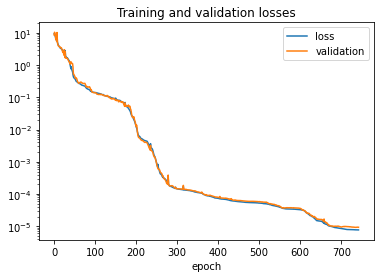

In [18]:
class PI_Model(tf.keras.models.Model):
    def __init__(self):
        super(PI_Model, self).__init__()
        
        # Define all layers
        self.dense_1 = tf.keras.layers.Dense(8, activation=tf.keras.activations.tanh)
        self.dense_2 = tf.keras.layers.Dense(8, activation=tf.keras.activations.tanh)        
        self.dense_3 = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)
        
        # Loss function to use later on
        self.loss_fun = tf.keras.losses.MeanSquaredError()
            
    # Forward pass for model
    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)        
        y = self.dense_3(x)
        return y        

    def get_derivatives(self, x_input):
        x = tf.constant(x_input)
        with tf.GradientTape() as g:
            g.watch(x)
            with tf.GradientTape() as gg:
                gg.watch(x)
                y = self(x)
            y_x = gg.gradient(y,x)
        y_xx = g.gradient(y_x,x)
        return y, y_x, y_xx
    
    def loss(self, X, Y):
        # data observation loss    
        y = self(X[0]) # y(x)
        # Physics loss        
        _, _, phys = self.get_derivatives(X[1]) # y''(x)
        return self.loss_fun(Y[0], y) + self.loss_fun(Y[1], phys) 
    
model = PI_Model()
model.build((1,1))

def generate_data(n_y, n_phys):
    # values of y
    x_obs = reshape_2d(np.linspace(-math.pi/2,math.pi/2,n_y))
    y_obs = np.cos(2*x_obs)

    # values for right-hand-side of the physics equation
    x_phys = reshape_2d(np.linspace(-math.pi,math.pi,n_phys))
    y_phys = -4*np.cos(2*x_phys)   
    
    X_data = [x_obs,x_phys]
    Y_data = [y_obs,y_phys]
    
    return X_data, Y_data

X_train, Y_train = generate_data(2, 32)
X_val, Y_val = generate_data(64, 64)

result = model_fit(model, X_train, Y_train, validation_data=(X_val, Y_val), epochs=1000, iprint=200, figname ='fig/piml_loss.png')

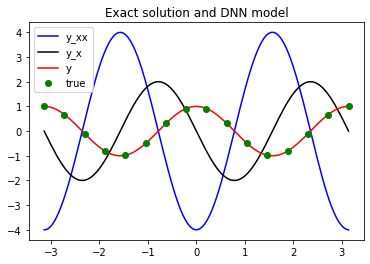

In [21]:
# Plot the solution
x_true = reshape_2d(np.linspace(-math.pi,math.pi,16))
x_test = reshape_2d(np.linspace(-math.pi,math.pi,128))

y_pred, y_x_pred, y_xx_pred = model.get_derivatives(x_test)

plt.plot(x_test,y_xx_pred,'b',label='y_xx')
plt.plot(x_test,y_x_pred,'k',label='y_x')
plt.plot(x_test,y_pred,'r',label='y')
plt.plot(x_true,np.cos(2*x_true),'go',label='true')
plt.title('Exact solution and DNN model')
plt.legend()
plt.savefig('fig/piml_solution.png',dpi=300)